# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

The first project is about finding lanes in a series of images using the canny edge detector algorithm and the hough transformation to find lines. Some filtering have to be done to stabilize noisy detections. 

## Import Packages and define some functions

These functions are provided by the udacity team

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

import os
dir_list = os.listdir("test_images/")   


## Fist task: Detect lines on single images

Entry task is to detect the lane lines on single images. The detected lines by the hough transformation have to be averaged only for one frame. 


test_images/solidYellowCurve2.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
test_images/solidWhiteCurve.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
test_images/solidYellowLeft.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
test_images/solidWhiteRight.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
test_images/solidYellowCurve.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
test_images/whiteCarLaneSwitch.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


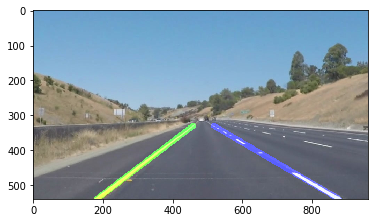

In [2]:
# Building a lane finding pipeline 
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# ---------------------- CONSTANTS -------------------------------

# define gaussian filter kernel size to reduce image noise  
kernel_size = 7

# Define our parameters for Canny 
low_threshold = 50
high_threshold = 150

# Define the Hough transform parameters
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 30     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 15 #minimum number of pixels making up a line
max_line_gap = 10   # maximum gap in pixels between connectable line segments

# ROI scalings in percent of imageg size 
# bottom left, top left, top right, bottom right 
bottom_left_roi_scale_x = 0.1241
bottom_left_roi_scale_y = 0.92

top_left_roi_scale_x = 0.40
top_left_roi_scale_y = 0.65

top_right_roi_scale_x = 0.6
top_right_roi_scale_y = 0.65

bottom_right_scale_x = 0.9075
bottom_right_scale_y = 0.92


# ---------------------- PROCESSING -------------------------------

# Loading images from directory 
for dir in dir_list: 
    print("test_images/"+dir)

    # Load from path 
    image = mpimg.imread("test_images/"+dir)
    imshape = image.shape

    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    
    gray = grayscale(image)

    # Blur the image with the gaussian filter 
    # gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    gray = gaussian_blur(gray, kernel_size)

    # Calculate edges with canny algorithm 
    edges = canny(gray, low_threshold, high_threshold)

    # Because the second video have another size but the same side ratio define ROI in % of image size 
    # This would not work if image size not has same side ratio 
    #vertices = np.array([[(100,imshape[0]),(450, 320), (550, 320), (900,imshape[0])]], dtype=np.int32)
    # imshape[0] = ROWS = y 
    # imshape[1] = COLS = x 
    # np.array([[(x,y),(x,y), (x,y), (x,y), ... n-coordiantes ... ]], dtype=np.int32)
    vertices = np.array([[(imshape[1]*bottom_left_roi_scale_x,imshape[0]*bottom_left_roi_scale_y),(imshape[1]*top_left_roi_scale_x, imshape[0]*top_left_roi_scale_y), (imshape[1]*top_right_roi_scale_x,  imshape[0]*top_right_roi_scale_y), (imshape[1]*bottom_right_scale_x,imshape[0]*bottom_right_scale_y)]], dtype=np.int32)
    
    masked_edge_image = region_of_interest(edges, vertices)

    # hough_lines function does not return lines - so I call the cv2.HoughLinesP function directly to get lines g
    lines = cv2.HoughLinesP(masked_edge_image, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    line_image = np.zeros((masked_edge_image.shape[0], masked_edge_image.shape[1], 3), dtype=np.uint8)
    draw_lines(line_image, lines)

    left_count = 0
    right_count = 0
    left_slope_avg = 0
    right_slope_avg = 0
    left_pos_avg = 0 
    right_pos_avg = 0

    # Tried to define integer vetors but they change their type later on!? 
    left_pos_avg = np.zeros((4,) , dtype=np.int);
    right_pos_avg = np.zeros((4,) , dtype=np.int);

    # Sorting and averaging the slope of the calculated line segments 
    for line in lines:
        for x1,y1,x2,y2 in line:
                #print('x1:', x1, ' y1:', y1, ' x2:', x2, ' y2:', y2 )
                slope = ((y2-y1)/(x2-x1))
                #print('Slope: ', slope) 
                if slope < 0: 
                    #print('right')
                    right_count = right_count + 1
                    right_slope_avg = right_slope_avg + slope
                    right_pos_avg[0] = right_pos_avg[0] + x1 + x2
                    right_pos_avg[1] = right_pos_avg[1] + y1 + y2 
                else: 
                    #print('left')
                    left_count = left_count +1 
                    left_slope_avg = left_slope_avg + slope 
                    left_pos_avg[0] = left_pos_avg[0] + x1 + x2 
                    left_pos_avg[1] = left_pos_avg[1] + y1 + y2 
    
    # Averaging slope and x,y position for one frame
    left_slope_avg = left_slope_avg / left_count
    right_slope_avg = right_slope_avg / right_count 
    left_pos_avg = left_pos_avg / (left_count*2) 
    right_pos_avg = right_pos_avg / (right_count*2)

    # Using line equation to calculate new averaged lines 
    # y = kx + d 

    # Calculating intersection of line with y axis with calculated slope 
    # and the averaged position 
    # d = y - kx 
    d_left = left_pos_avg[1] - left_slope_avg*left_pos_avg[0]
    d_right = right_pos_avg[1] - right_slope_avg*right_pos_avg[0]

    # Calculating x coordinates at max y (number of rows) --> where to start at the bottom of the image 
    # x = (y-d)/k
    left_pos_avg[3]  = imshape[0]
    right_pos_avg[3] = imshape[0]

    left_pos_avg[2] = (left_pos_avg[3] - d_left)/left_slope_avg 
    right_pos_avg[2] = (right_pos_avg[3] - d_right)/(right_slope_avg)

    # Calculating second point for line drawing - 330 height is choosen so that they do not intersect 
    # --> Where to end the line so that it looks neat 
    left_pos_avg[0] =(330 - d_left)/(left_slope_avg)
    left_pos_avg[1] = 330
    right_pos_avg[0] =(330 - d_right)/(right_slope_avg)
    right_pos_avg[1] = 330 

    # Drawing debug image 
    cv2.line(line_image, (int(right_pos_avg[0]), int(right_pos_avg[1])), (int(right_pos_avg[2]), int(right_pos_avg[3])), [0, 255, 0], 4)
    cv2.line(line_image, (int(left_pos_avg[0]), int(left_pos_avg[1])), (int(left_pos_avg[2]), int(left_pos_avg[3])), [0, 0, 255], 4)

    # Drawing output image --> make a blank copy for overlay 
    image_overlay = np.copy(image)*0 

    cv2.line(image_overlay, (int(right_pos_avg[0]), int(right_pos_avg[1])), (int(right_pos_avg[2]), int(right_pos_avg[3])), [0, 255, 0], 16)
    cv2.line(image_overlay, (int(left_pos_avg[0]), int(left_pos_avg[1])), (int(left_pos_avg[2]), int(left_pos_avg[3])), [0, 0, 255], 16)

    overlayed_image = weighted_img(image_overlay, image, 1.0, 0.8)

   
    
    # ---------------------- DEBUG -------------------------------
    
    # Debug messages - are there preprocessor directives in python!? 
    show_debug_messages = False
    
    if show_debug_messages == True: 
        print('---------------------------------------------')
        print('d_left: ', d_left)
        print('d_right: ', d_right)
        print('right count', right_count)
        print('left_count', left_count)
        print('left slope average: ', left_slope_avg)
        print('right slope average: ', right_slope_avg)
        print('right pos average x1: ', right_pos_avg[0], ' y1:',  right_pos_avg[1], 'x2: ', right_pos_avg[2], ' y2:',  right_pos_avg[3])
        print('left pos average x1: ', left_pos_avg[0], ' y1:',  left_pos_avg[1], 'x2: ', left_pos_avg[2], ' y2:',  left_pos_avg[3])

    # Show gaussian blurred imaged 
    #plt.imshow(gray, cmap='gray')
    
    # Show edged picture 
    #plt.imshow(masked_edge_image, cmap = 'gray')
    
    # Show segmented lines 
    #plt.imshow(line_image, cmap = 'gray')
    
    draw_roi = False
    
    if draw_roi == True:
        cv2.line(overlayed_image, (int(imshape[1]*bottom_left_roi_scale_x), int(imshape[0]*bottom_left_roi_scale_y)), (int(imshape[1]*top_left_roi_scale_x), int(imshape[0]*top_left_roi_scale_y)), [0, 255, 0], 1)
        cv2.line(overlayed_image, (int(imshape[1]*top_left_roi_scale_x), int(imshape[0]*top_left_roi_scale_y)), (int(imshape[1]*top_right_roi_scale_x), int(imshape[0]*top_right_roi_scale_y)), [0, 255, 0], 1)
        cv2.line(overlayed_image, (int(imshape[1]*top_right_roi_scale_x), int(imshape[0]*top_right_roi_scale_y)), (int(imshape[1]*bottom_right_scale_x), int(imshape[0]*bottom_right_scale_y)), [0, 255, 0], 1)
        cv2.line(overlayed_image, (int(imshape[1]*bottom_right_scale_x), int(imshape[0]*bottom_right_scale_y)), (int(imshape[1]*bottom_left_roi_scale_x), int(imshape[0]*bottom_left_roi_scale_y)), [0, 255, 0], 1)

    
    # Show segmented lines 
    plt.imshow(overlayed_image)
     
    # Because imread swappes R and B 
    cv2.imwrite("test_images_output/"+dir, cv2.cvtColor(overlayed_image, cv2.COLOR_RGB2BGR))


## Second task: Detect lines on a stream of images (video)

In the second task the lines have to be detected in a series of successive images. Now it makes sense to keep data throughout the frames to stabilize noisy detections of the lane marking slopes and positions. 

Importing further libraries: 

In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from math import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


Redefining my constants because even on my on edge 24" monitor it is a long way to scroll up to the top. 

Defining some globals to be able to keep data throughout the frames. 

In [23]:
# ---------------------- CONSTANTS AND GLOBALS -------------------------------

# define gaussian filter kernel size to reduce image noise  
kernel_size = 7

# Define our parameters for Canny 
low_threshold = 50
high_threshold = 150

# Define the Hough transform parameters
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 30     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 15 #minimum number of pixels making up a line
max_line_gap = 10   # maximum gap in pixels between connectable line segments


# ROI scalings in percent of imageg size 
# bottom left, top left, top right, bottom right 
bottom_left_roi_scale_x = 0.1241
bottom_left_roi_scale_y = 0.92

top_left_roi_scale_x = 0.40
top_left_roi_scale_y = 0.65

top_right_roi_scale_x = 0.6
top_right_roi_scale_y = 0.65

bottom_right_scale_x = 0.9075
bottom_right_scale_y = 0.92

# Using this like a c struct 
class Statistics:
    count = 0.0
    mean = 0.0
    var = 0.0
    M2 = 0.0

filtered_d_right = Statistics()
filtered_d_left = Statistics() 

filtered_d_right.mean = 5.0
filtered_d_right.var = 9999.0

filtered_d_left.mean = 640.0
filtered_d_left.var = 9999.0
    
slope_right = Statistics() 
# Using apriori knowledge to initialize slope of line 
slope_right.mean = -0.7
slope_right.var = 0.002

slope_left = Statistics()
# Using apriori knowledge to initialize slope of line 
slope_left.mean = 0.6
slope_left.var = 0.002
    
filtered_slope_right = Statistics()
filtered_slope_right.var = 9999.0
filtered_slope_right.mean = -0.7

filtered_slope_left = Statistics()
filtered_slope_left.var = 99999.0
filtered_slope_left.mean = 0.6

plot_slope_left_filtered=[]
plot_slope_left=[]

plot_slope_right_filtered=[]
plot_slope_right=[]

plot_d_right_filtered=[]
plot_d_right=[]
plot_d_left_filtered=[]
plot_d_left=[]
frame=[]
frame_counter = 0

# Tried to define integer vetors but they change their type later on!? 
left_pos_avg = np.zeros((4,) , dtype=np.int);
right_pos_avg = np.zeros((4,) , dtype=np.int);

def update(mean1, var1, mean2, var2):
    new_mean = float(var2 * mean1 + var1 * mean2) / (var1 + var2)
    new_var = 1./(1./var1 + 1./var2)
    return (new_mean, new_var)

def predict(mean1, var1, mean2, var2):
    new_mean = mean1 + mean2
    new_var = var1 + var2
    return (new_mean, new_var)


def calc_mean_welford(x, mean, M2, n): 
    n = n + 1
    delta = x - mean
    mean += delta/n
    delta2 = x - mean
    M2 += delta*delta2
    return (mean, M2, n)

def calc_var_welford(n, M2, var): 
    if n < 2: # not enough sample points to estimate variance 
        var = var # using last variance 
    else:
        var = (M2 / (n -1)) # Estimating variance
        #print('right_slope_mean: ', slope_right.mean, ' var: ', slope_right.var) 
    return (var)


def process_image(image):
    global left_pos_avg
    global right_pos_avg
    global slope_left
    global slope_right 
    global filtered_slope_left
    global filtered_slope_right
    global filtered_d_right
    global filtered_d_left 
    
    global plot_slope_left_filtered
    global plot_slope_left
    global plot_slope_right_filtered
    global plot_slope_right

    global plot_d_right_filtered
    global plot_d_right
    global plot_d_left_filtered
    global plot_d_left
    
    global frame
    global frame_counter 
    
    frame_counter = frame_counter + 1
    frame.append(frame_counter)
    
    gray = grayscale(image)

    # Blur the image with the gaussian filter 
    # gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny 
    edges = canny(gray, low_threshold, high_threshold)

    # Because the second video have another size but the same side ratio define ROI in % of image size 
    # This would not work if image size not has same side ratio 
    imshape = edges.shape
        
    vertices = np.array([[(imshape[1]*bottom_left_roi_scale_x,imshape[0]*bottom_left_roi_scale_y),(imshape[1]*top_left_roi_scale_x, imshape[0]*top_left_roi_scale_y), (imshape[1]*top_right_roi_scale_x,  imshape[0]*top_right_roi_scale_y), (imshape[1]*bottom_right_scale_x,imshape[0]*bottom_right_scale_y)]], dtype=np.int32)
    masked_edge_image = region_of_interest(edges, vertices)
       
    # hough_lines function does not return lines - so I call the cv2.HoughLinesP function directly to get lines g
    lines = cv2.HoughLinesP(masked_edge_image, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
   
   # Tried to define integer vetors but they change their type later on!? 
    frame_left_pos_avg = np.zeros((4,) , dtype=np.int);
    frame_right_pos_avg = np.zeros((4,) , dtype=np.int);
      
    slope_left.count = 0
    slope_right.count = 0
   
    right_slope_avg = slope_right.mean 
    left_slope_avg = slope_left.mean 

    # Sorting and averaging the slope of the calculated line segments 
    for line in lines:
        for x1,y1,x2,y2 in line:
                #print('x1:', x1, ' y1:', y1, ' x2:', x2, ' y2:', y2 )
                slope = ((y2-y1)/(x2-x1))
                #print('Slope: ', slope) 
                
                if (slope < 0.75 and slope > 0.55) or (slope < -0.55 and slope > -0.75):       
                    if slope > 0:
                        #print('right')

                        frame_right_pos_avg[0] = frame_right_pos_avg[0] + x1 + x2
                        frame_right_pos_avg[1] = frame_right_pos_avg[1] + y1 + y2 

                        slope_right.mean, slope_right.M2, slope_right.count = calc_mean_welford(slope, slope_right.mean, slope_right.M2, slope_right.count)
                    else: 
                        #print('left')
                        frame_left_pos_avg[0] = frame_left_pos_avg[0] + x1 + x2 
                        frame_left_pos_avg[1] = frame_left_pos_avg[1] + y1 + y2 

                        slope_left.mean, slope_left.M2, slope_left.count = calc_mean_welford(slope, slope_left.mean, slope_left.M2, slope_left.count)
                else: 
                    print('Outlier slope... skipping')
    #print('--------------------------------------------')      
                    
    if slope_left.count > 0 and slope_right.count > 0:
        left_pos_avg = frame_left_pos_avg / (slope_left.count*2) 
        right_pos_avg = frame_right_pos_avg / (slope_right.count*2)
 
        slope_right.var = calc_var_welford(slope_right.count, slope_right.M2, slope_right.var)
        #print('right_slope_mean: ', slope_right.mean, ' var: ', slope_right.var)     

        slope_left.var = calc_var_welford(slope_left.count, slope_left.M2, slope_left.var)
        #print('left_slope_mean: ', slope_left.mean, ' var: ', slope_left.var)   
        
        right_slope_avg = slope_right.mean 
        left_slope_avg = slope_left.mean 
    else:
        print('No detections on right or left line - using previous results')
    
    #########################################################################
    # Filtering calculated slopes 
    
    # ---------------------------- Right slope  
    plot_slope_right.append(slope_right.mean)
    
    filtered_slope_right.mean, filtered_slope_right.var = update(filtered_slope_right.mean,filtered_slope_right.var,slope_right.mean,0.1)#slope_right.var)
    filtered_slope_right.mean, filtered_slope_right.var = predict(filtered_slope_right.mean,filtered_slope_right.var,0.0,0.0025)#0.000001)

    plot_slope_right_filtered.append(filtered_slope_right.mean)

    right_slope_avg = filtered_slope_right.mean
    

    # ---------------------------- left slope  
    plot_slope_left.append(slope_left.mean)

    filtered_slope_left.mean, filtered_slope_left.var = update(filtered_slope_left.mean,filtered_slope_left.var,slope_left.mean,0.1)#slope_left.var)
    filtered_slope_left.mean, filtered_slope_left.var = predict(filtered_slope_left.mean,filtered_slope_left.var,0.0,0.0025)#0.000001)
   
    left_slope_avg = filtered_slope_left.mean

    plot_slope_left_filtered.append(filtered_slope_left.mean)

    #########################################################################
    # Using line equation to calculate new lines from averaged slopes 
    # y = kx + d 

    # Calculating d translation on y axis of a line with the calculated slope running through the averages x,y coordinates 
    # d = y - kx 

    d_left = left_pos_avg[1] - left_slope_avg*left_pos_avg[0]
    d_right = right_pos_avg[1] - right_slope_avg*right_pos_avg[0]

    
    # ---------------------------- Right d  
    plot_d_right.append(d_right)
    
    filtered_d_right.mean, filtered_d_right.var = update(filtered_d_right.mean,filtered_d_right.var,d_right,10.0)
    filtered_d_right.mean, filtered_d_right.var = predict(filtered_d_right.mean,filtered_d_right.var,0.0,1.5)
   
    plot_d_right_filtered.append(filtered_d_right.mean)
 
    # ---------------------------- Left d  
    plot_d_left.append(d_left)

    filtered_d_left.mean, filtered_d_left.var = update(filtered_d_left.mean,filtered_d_left.var,d_left,10.0)
    filtered_d_left.mean, filtered_d_left.var = predict(filtered_d_left.mean,filtered_d_left.var,0.0,1.5)
    
    plot_d_left_filtered.append(filtered_d_left.mean)
    
    d_right = filtered_d_right.mean
    d_left = filtered_d_left.mean

    
    # Calculating x coordinates at max y (number of rows) --> where to start at the bottom of the image 
    # x = (y-d)/k
    left_pos_avg[3]  = imshape[0]
    right_pos_avg[3] = imshape[0]

    left_pos_avg[2] = (left_pos_avg[3] - d_left)/left_slope_avg 
    right_pos_avg[2] = (right_pos_avg[3] - d_right)/(right_slope_avg)
    
    # Calculating second point for line drawing - 330 height is choosen so that they do not intersect 
    # --> Where to end the line so that it looks neat 
    corp_height = imshape[0] * 0.61
    
    left_pos_avg[0] =(corp_height - d_left)/(left_slope_avg)
    left_pos_avg[1] = corp_height
   
    right_pos_avg[0] =(corp_height - d_right)/(right_slope_avg)
    right_pos_avg[1] = corp_height 
   
    # Drawing output image --> make a blank copy for overlay
    image_overlay = np.copy(image)*0  
    
    # Drawing calculated lines on overlay image 
    cv2.line(image_overlay, (int(right_pos_avg[0]), int(right_pos_avg[1])), (int(right_pos_avg[2]), int(right_pos_avg[3])), [0, 255, 0], 16)
    cv2.line(image_overlay, (int(left_pos_avg[0]), int(left_pos_avg[1])), (int(left_pos_avg[2]), int(left_pos_avg[3])), [0, 0, 255], 16)
        
    # Generating overlayed output image
    result = weighted_img(image_overlay, image, 1.0, 0.8)
        
    # ---------------------- DEBUG -------------------------------
    
    # Debug messages - are there preprocessor directives in python!? 
    show_debug_messages = False
    
    if show_debug_messages == True: 
        print('---------------------------------------------')
        print('d_left: ', d_left)
        print('d_right: ', d_right)
        print('right count', right_count)
        print('left_count', left_count)
        print('left slope average: ', left_slope_avg)
        print('right slope average: ', right_slope_avg)
        print('right pos average x1: ', right_pos_avg[0], ' y1:',  right_pos_avg[1], 'x2: ', right_pos_avg[2], ' y2:',  right_pos_avg[3])
        print('left pos average x1: ', left_pos_avg[0], ' y1:',  left_pos_avg[1], 'x2: ', left_pos_avg[2], ' y2:',  left_pos_avg[3])

    show_hough_line_image = False
    
    if show_hough_line_image == True:
        line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

        cv2.line(line_image, (int(imshape[1]*bottom_left_roi_scale_x), int(imshape[0]*bottom_left_roi_scale_y)), (int(imshape[1]*top_left_roi_scale_x), int(imshape[0]*top_left_roi_scale_y)), [0, 255, 0], 1)
        cv2.line(line_image, (int(imshape[1]*top_left_roi_scale_x), int(imshape[0]*top_left_roi_scale_y)), (int(imshape[1]*top_right_roi_scale_x), int(imshape[0]*top_right_roi_scale_y)), [0, 255, 0], 1)
        cv2.line(line_image, (int(imshape[1]*top_right_roi_scale_x), int(imshape[0]*top_right_roi_scale_y)), (int(imshape[1]*bottom_right_scale_x), int(imshape[0]*bottom_right_scale_y)), [0, 255, 0], 1)
        cv2.line(line_image, (int(imshape[1]*bottom_right_scale_x), int(imshape[0]*bottom_right_scale_y)), (int(imshape[1]*bottom_left_roi_scale_x), int(imshape[0]*bottom_left_roi_scale_y)), [0, 255, 0], 1)


        draw_lines(line_image, lines)
        result = weighted_img(line_image, image, 1.0, 0.8)
         
    return result

In [24]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,1)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Outlier slope... skipping
Outlier slope... skipping
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  2%|▏         | 5/222 [00:00<00:04, 44.59it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping


  7%|▋         | 16/222 [00:00<00:04, 47.43it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 18%|█▊        | 39/222 [00:00<00:03, 51.74it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 20%|█▉        | 44/222 [00:00<00:03, 48.94it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 24%|██▍       | 53/222 [00:01<00:05, 31.76it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 52%|█████▏    | 116/222 [00:03<00:04, 25.78it/s]

Outlier slope... skipping


 64%|██████▎   | 141/222 [00:04<00:02, 29.47it/s]

Outlier slope... skipping


 67%|██████▋   | 148/222 [00:05<00:02, 26.67it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 69%|██████▉   | 154/222 [00:05<00:02, 23.72it/s]

Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 73%|███████▎  | 161/222 [00:05<00:02, 23.59it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results


 75%|███████▌  | 167/222 [00:05<00:02, 22.65it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results


 77%|███████▋  | 170/222 [00:05<00:02, 23.26it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results


 80%|███████▉  | 177/222 [00:06<00:01, 24.94it/s]

Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results


 83%|████████▎ | 184/222 [00:06<00:01, 24.10it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using p

 84%|████████▍ | 187/222 [00:06<00:01, 22.75it/s]

No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results


 88%|████████▊ | 195/222 [00:06<00:01, 25.78it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping


 91%|█████████ | 201/222 [00:07<00:00, 25.52it/s]

No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping

 94%|█████████▎| 208/222 [00:07<00:00, 24.82it/s]


Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results


 95%|█████████▌| 212/222 [00:07<00:00, 26.83it/s]

No detections on right or left line - using previous results
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results


 98%|█████████▊| 218/222 [00:07<00:00, 25.09it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


100%|█████████▉| 221/222 [00:07<00:00, 25.43it/s]


Outlier slope... skipping
Outlier slope... skipping
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.46 s, sys: 248 ms, total: 5.71 s
Wall time: 8.98 s


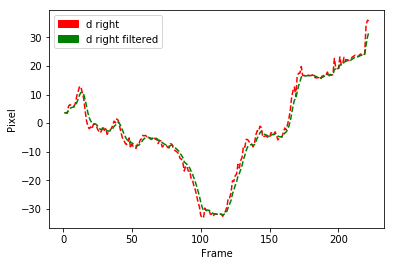

In [25]:
red_patch = mpatches.Patch(color='red', label='d right')
green_patch = mpatches.Patch(color='green', label='d right filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_d_right, 'r--', frame, plot_d_right_filtered, 'g--')
plt.show()

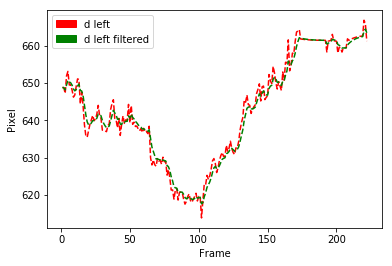

In [26]:
red_patch = mpatches.Patch(color='red', label='d left')
green_patch = mpatches.Patch(color='green', label='d left filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_d_left, 'r--', frame, plot_d_left_filtered, 'g--')
plt.show()

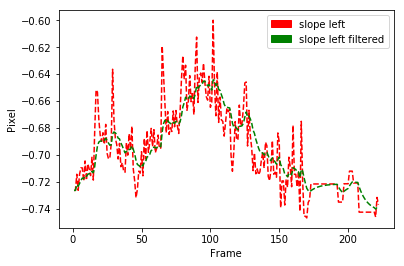

In [27]:
red_patch = mpatches.Patch(color='red', label='slope left')
green_patch = mpatches.Patch(color='green', label='slope left filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_slope_left, 'r--', frame, plot_slope_left_filtered, 'g--')
plt.show()

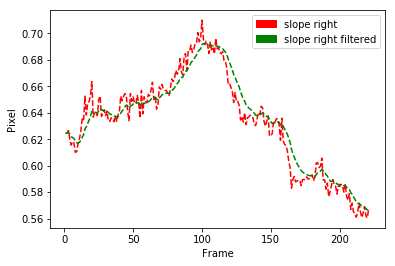

In [28]:
red_patch = mpatches.Patch(color='red', label='slope right')
green_patch = mpatches.Patch(color='green', label='slope right filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_slope_right, 'r--', frame, plot_slope_right_filtered, 'g--')
plt.show()

In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [30]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,3)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  5%|▌         | 37/682 [00:00<00:11, 57.98it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


  6%|▋         | 43/682 [00:00<00:11, 55.16it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


  8%|▊         | 54/682 [00:01<00:16, 36.97it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


  9%|▊         | 59/682 [00:01<00:19, 32.25it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 24%|██▎       | 161/682 [00:05<00:19, 26.30it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 25%|██▍       | 168/682 [00:05<00:21, 23.87it/s]

Outlier slope... skipping
Outlier slope... skipping


 26%|██▌       | 176/682 [00:05<00:19, 25.95it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping

 26%|██▌       | 179/682 [00:05<00:21, 22.93it/s]


Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 27%|██▋       | 182/682 [00:05<00:20, 23.99it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results


 28%|██▊       | 189/682 [00:06<00:20, 23.49it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slo

 29%|██▉       | 197/682 [00:06<00:19, 25.52it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Ou

 30%|██▉       | 204/682 [00:06<00:17, 27.49it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... ski

 31%|███       | 211/682 [00:07<00:17, 26.61it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 32%|███▏      | 217/682 [00:07<00:17, 26.33it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 32%|███▏      | 220/682 [00:07<00:17, 26.13it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 33%|███▎      | 226/682 [00:07<00:18, 24.26it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 34%|███▍      | 232/682 [00:07<00:17, 26.08it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 35%|███▌      | 242/682 [00:08<00:15, 28.06it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 37%|███▋      | 249/682 [00:08<00:15, 27.42it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 38%|███▊      | 260/682 [00:08<00:14, 29.74it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 39%|███▊      | 264/682 [00:09<00:15, 26.34it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 41%|████      | 278/682 [00:09<00:17, 23.13it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 42%|████▏     | 285/682 [00:09<00:16, 23.72it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 42%|████▏     | 288/682 [00:10<00:19, 20.06it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 43%|████▎     | 292/682 [00:10<00:17, 22.58it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 44%|████▎     | 298/682 [00:10<00:19, 19.64it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 45%|████▍     | 304/682 [00:10<00:16, 22.82it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 46%|████▌     | 311/682 [00:11<00:14, 24.83it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 46%|████▋     | 317/682 [00:11<00:14, 25.95it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 47%|████▋     | 323/682 [00:11<00:12, 27.67it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 49%|████▉     | 333/682 [00:11<00:13, 25.48it/s]

Outlier slope... skipping
Outlier slope... skipping


 54%|█████▍    | 367/682 [00:13<00:11, 27.85it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 55%|█████▍    | 373/682 [00:13<00:11, 27.07it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 56%|█████▌    | 379/682 [00:13<00:11, 25.76it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 57%|█████▋    | 386/682 [00:13<00:11, 26.47it/s]

Outlier slope... skipping
Outlier slope... skipping


 62%|██████▏   | 422/682 [00:15<00:09, 27.49it/s]

Outlier slope... skipping


 66%|██████▌   | 447/682 [00:16<00:08, 26.55it/s]

Outlier slope... skipping


 71%|███████   | 481/682 [00:17<00:11, 17.42it/s]

Outlier slope... skipping
Outlier slope... skipping


 82%|████████▏ | 558/682 [00:21<00:05, 23.37it/s]

Outlier slope... skipping
Outlier slope... skipping


 84%|████████▎ | 570/682 [00:22<00:05, 21.97it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 84%|████████▍ | 576/682 [00:22<00:04, 23.40it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 85%|████████▌ | 582/682 [00:23<00:04, 21.02it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 86%|████████▌ | 585/682 [00:23<00:05, 17.70it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 86%|████████▌ | 588/682 [00:23<00:04, 19.04it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 87%|████████▋ | 595/682 [00:23<00:04, 19.96it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 88%|████████▊ | 599/682 [00:23<00:03, 22.88it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 89%|████████▉ | 606/682 [00:24<00:03, 22.58it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 89%|████████▉ | 609/682 [00:24<00:03, 21.71it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results


 90%|█████████ | 615/682 [00:24<00:02, 22.93it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Ou

 91%|█████████ | 621/682 [00:24<00:02, 23.39it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line -

 92%|█████████▏| 627/682 [00:25<00:02, 24.24it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Ou

 93%|█████████▎| 633/682 [00:25<00:02, 21.36it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slo

 94%|█████████▍| 640/682 [00:25<00:01, 25.17it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Ou

 94%|█████████▍| 643/682 [00:25<00:01, 23.77it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Ou

 95%|█████████▌| 650/682 [00:25<00:01, 25.48it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Ou

 96%|█████████▌| 653/682 [00:26<00:01, 23.51it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... sk

 97%|█████████▋| 660/682 [00:26<00:00, 24.55it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 98%|█████████▊| 666/682 [00:26<00:00, 25.64it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


100%|█████████▉| 679/682 [00:27<00:00, 26.84it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


100%|█████████▉| 681/682 [00:27<00:00, 25.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 19 s, sys: 768 ms, total: 19.7 s
Wall time: 28.4 s


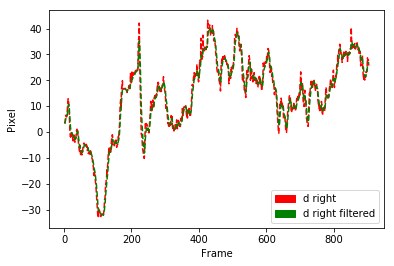

In [31]:
red_patch = mpatches.Patch(color='red', label='d right')
green_patch = mpatches.Patch(color='green', label='d right filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_d_right, 'r--', frame, plot_d_right_filtered, 'g--')
plt.show()

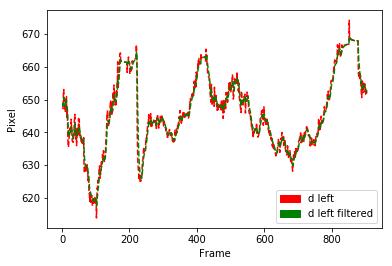

In [32]:
red_patch = mpatches.Patch(color='red', label='d left')
green_patch = mpatches.Patch(color='green', label='d left filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_d_left, 'r--', frame, plot_d_left_filtered, 'g--')
plt.show()

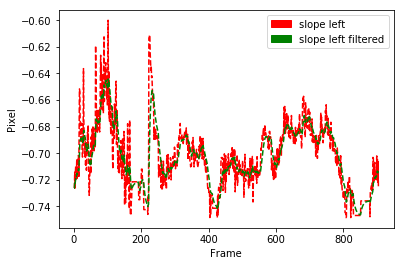

In [33]:
red_patch = mpatches.Patch(color='red', label='slope left')
green_patch = mpatches.Patch(color='green', label='slope left filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_slope_left, 'r--', frame, plot_slope_left_filtered, 'g--')
plt.show()

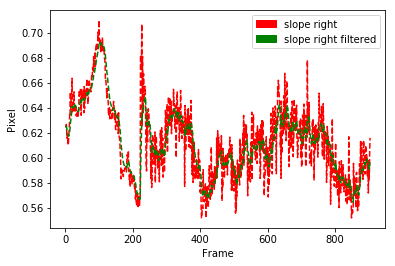

In [34]:
red_patch = mpatches.Patch(color='red', label='slope right')
green_patch = mpatches.Patch(color='green', label='slope right filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_slope_right, 'r--', frame, plot_slope_right_filtered, 'g--')
plt.show()

In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [36]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,2)
clip3 = VideoFileClip('test_videos/challenge.mp4')

print('Height: ' , clip3.h, ' Width: ', clip3.w)

challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Height:  720  Width:  1280
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  2%|▏         | 4/251 [00:00<00:07, 31.56it/s]

Outlier slope... skipping
Outlier slope... skipping


  6%|▌         | 14/251 [00:00<00:07, 30.36it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


  8%|▊         | 21/251 [00:00<00:07, 29.64it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 10%|▉         | 25/251 [00:00<00:07, 30.48it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 13%|█▎        | 33/251 [00:01<00:06, 31.93it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 18%|█▊        | 45/251 [00:01<00:06, 34.31it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 23%|██▎       | 58/251 [00:02<00:10, 17.59it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 24%|██▍       | 61/251 [00:02<00:11, 16.52it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 25%|██▌       | 63/251 [00:02<00:12, 15.58it/s]

Outlier slope... skipping
Outlier slope... skipping


 29%|██▉       | 74/251 [00:03<00:12, 14.26it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 32%|███▏      | 80/251 [00:03<00:12, 13.86it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 33%|███▎      | 84/251 [00:04<00:14, 11.90it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 35%|███▍      | 87/251 [00:04<00:12, 13.60it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Out

 36%|███▋      | 91/251 [00:04<00:14, 11.42it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Out

 38%|███▊      | 95/251 [00:05<00:11, 13.04it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Out

 39%|███▊      | 97/251 [00:05<00:12, 12.47it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slop

 40%|████      | 101/251 [00:05<00:11, 13.15it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... ski

 41%|████      | 103/251 [00:05<00:10, 13.99it/s]


Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... sk

 42%|████▏     | 105/251 [00:05<00:12, 12.16it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slop

 43%|████▎     | 109/251 [00:06<00:10, 13.50it/s]

Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... ski

 45%|████▍     | 112/251 [00:06<00:09, 15.01it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 46%|████▌     | 116/251 [00:06<00:10, 13.04it/s]

No detections on right or left line - using previous results
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
No detections on right or left line - using previous results


 47%|████▋     | 118/251 [00:06<00:09, 13.41it/s]

No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results


 48%|████▊     | 120/251 [00:07<00:10, 12.72it/s]

Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
No detections on right or left line - using previous results


 49%|████▉     | 124/251 [00:07<00:16,  7.84it/s]

No detections on right or left line - using previous results
No detections on right or left line - using previous results
No detections on right or left line - using previous results


 50%|█████     | 126/251 [00:08<00:15,  8.20it/s]

No detections on right or left line - using previous results
No detections on right or left line - using previous results
No detections on right or left line - using previous results
No detections on right or left line - using previous results


 51%|█████▏    | 129/251 [00:08<00:18,  6.72it/s]

Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
No detections on right or left line - using previous results


 53%|█████▎    | 133/251 [00:09<00:17,  6.58it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 54%|█████▍    | 135/251 [00:09<00:15,  7.37it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results


 55%|█████▍    | 138/251 [00:10<00:20,  5.64it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 55%|█████▌    | 139/251 [00:10<00:19,  5.79it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 56%|█████▌    | 141/251 [00:10<00:16,  6.81it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 57%|█████▋    | 143/251 [00:10<00:14,  7.28it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slop

 59%|█████▊    | 147/251 [00:11<00:12,  8.09it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slop

 59%|█████▉    | 149/251 [00:11<00:11,  9.21it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slop

 61%|██████    | 153/251 [00:11<00:09, 10.17it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 62%|██████▏   | 155/251 [00:12<00:09,  9.78it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 63%|██████▎   | 159/251 [00:12<00:07, 11.66it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 65%|██████▍   | 163/251 [00:12<00:08,  9.92it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 67%|██████▋   | 167/251 [00:13<00:07, 11.94it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 70%|██████▉   | 175/251 [00:13<00:06, 12.66it/s]

Outlier slope... skipping


 76%|███████▌  | 190/251 [00:15<00:06,  9.94it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 76%|███████▋  | 192/251 [00:15<00:05, 10.88it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 77%|███████▋  | 194/251 [00:15<00:06,  9.18it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 79%|███████▉  | 198/251 [00:16<00:05,  9.81it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 80%|███████▉  | 200/251 [00:16<00:04, 10.97it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 82%|████████▏ | 206/251 [00:16<00:03, 12.36it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 84%|████████▎ | 210/251 [00:17<00:03, 10.55it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 85%|████████▌ | 214/251 [00:17<00:03, 12.30it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results


 86%|████████▌ | 216/251 [00:17<00:03,  9.69it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results


 87%|████████▋ | 218/251 [00:18<00:03, 10.89it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results


 88%|████████▊ | 222/251 [00:18<00:02, 11.62it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results


 89%|████████▉ | 224/251 [00:18<00:02, 10.46it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 90%|█████████ | 226/251 [00:18<00:02, 11.33it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 92%|█████████▏| 230/251 [00:19<00:01, 12.16it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results


 94%|█████████▍| 236/251 [00:19<00:01, 13.40it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results


 95%|█████████▌| 239/251 [00:19<00:00, 13.77it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
No detections on right or left line - using previous results
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 96%|█████████▌| 241/251 [00:19<00:00, 13.21it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 98%|█████████▊| 245/251 [00:20<00:00, 13.66it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


 99%|█████████▉| 249/251 [00:20<00:00, 13.50it/s]

Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping


100%|██████████| 251/251 [00:20<00:00, 14.85it/s]


Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
Outlier slope... skipping
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 10.5 s, sys: 536 ms, total: 11 s
Wall time: 22.7 s


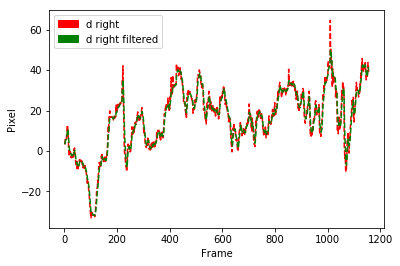

In [37]:
red_patch = mpatches.Patch(color='red', label='d right')
green_patch = mpatches.Patch(color='green', label='d right filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_d_right, 'r--', frame, plot_d_right_filtered, 'g--')
plt.show()

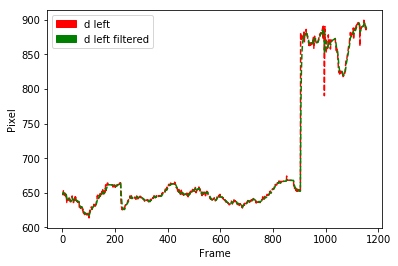

In [38]:
red_patch = mpatches.Patch(color='red', label='d left')
green_patch = mpatches.Patch(color='green', label='d left filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_d_left, 'r--', frame, plot_d_left_filtered, 'g--')
plt.show()

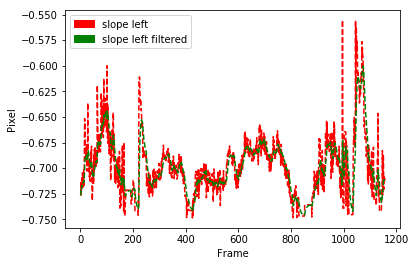

In [39]:
red_patch = mpatches.Patch(color='red', label='slope left')
green_patch = mpatches.Patch(color='green', label='slope left filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_slope_left, 'r--', frame, plot_slope_left_filtered, 'g--')
plt.show()

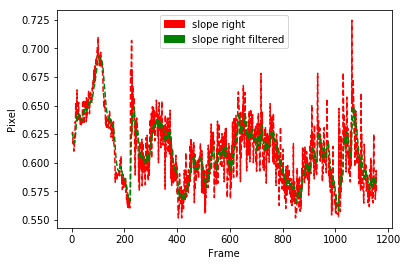

In [40]:
red_patch = mpatches.Patch(color='red', label='slope right')
green_patch = mpatches.Patch(color='green', label='slope right filtered')
plt.legend(handles=[red_patch, green_patch])
plt.ylabel('Pixel')
plt.xlabel('Frame')

plt.plot(frame, plot_slope_right, 'r--', frame, plot_slope_right_filtered, 'g--')
plt.show()

In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))